# Прогнозирование стоимости квартир на побережье Черного моря. 
# EDA
Цель данного упражнения:
* Ознакомиться с данными, которые у нас есть
* Понять, какую информацию мы сможем из них взять
* Понять, какие данные влияют на целевую переменную, а какие нет
* Понять, какие данные необходимо собирать из внешних источников
* Сформировать желаемый вид датасета, к которому будем стремиться преобразовать собранные данные

# Загрузка библиотек

In [1]:
#!pip install lightgbm

In [2]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from itertools import chain
from scipy.stats import ttest_ind

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from lightgbm import LGBMClassifier

%matplotlib inline

# Первичный осмотр данных
Посмотрим на выгруженные данные.

In [3]:
df = pd.read_csv('cian.csv')

In [4]:
display(df.head())
df.info()

,balconiesCount,category,flatType,floorNumber,fromDeveloper,isApartments,isAuction,kitchenArea,livingArea,loggiasCount,...,price,mortgageAllowed,region,city,floorsCount,buildYear,isComplete,passengerLiftsCount,cargoLiftsCount,materialType
0,NaN,newBuildingFlatSale,rooms,5.0,True,True,True,NaN,NaN,NaN,...,18288000,True,Крым,Ялта,10,NaN,True,1.0,0.0,monolith
1,NaN,flatSale,rooms,2.0,False,NaN,True,NaN,26.0,1.0,...,3984750,NaN,Крым,Ялта,6,2015.0,True,1.0,NaN,monolithBrick
2,NaN,newBuildingFlatSale,rooms,15.0,True,True,True,NaN,NaN,NaN,...,14580000,True,Крым,Ялта,18,NaN,True,1.0,0.0,monolith
3,NaN,newBuildingFlatSale,rooms,7.0,True,False,True,NaN,NaN,NaN,...,5200000,True,Крым,Ялта,8,NaN,True,1.0,0.0,monolith
4,1.0,newBuildingFlatSale,rooms,6.0,True,True,True,NaN,NaN,NaN,...,21024000,True,Крым,Ялта,10,NaN,True,1.0,0.0,monolith


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36509 entries, 0 to 36508
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   balconiesCount       19927 non-null  float64
 1   category             36509 non-null  object 
 2   flatType             36509 non-null  object 
 3   floorNumber          36508 non-null  float64
 4   fromDeveloper        36509 non-null  bool   
 5   isApartments         20701 non-null  object 
 6   isAuction            36509 non-null  bool   
 7   kitchenArea          20365 non-null  float64
 8   livingArea           20737 non-null  float64
 9   loggiasCount         17307 non-null  float64
 10  roomsCount           33761 non-null  float64
 11  totalArea            36509 non-null  float64
 12  price                36509 non-null  int64  
 13  mortgageAllowed      25381 non-null  object 
 14  region               36509 non-null  object 
 15  city                 36509 non-null 

Нам удалось выгрузить с cian 22 признака, некоторые содержат пропуски.

# Вспомогательные функции

Напишем функции, которае помогут нам при анализе переменных

In [5]:
# функция для визуализации распределения числовых признаков

def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

In [6]:
# функции для анализа признаков
# для числовых признаков
def num_info(column):
    print('Количество пропусков: {},'.format(column.isnull().sum()))
    print('{},'.format(column.describe()))
    visualize_distributions({column.name: column})

# для категориальных признаков
def cat_info(column):
    print('Количество пропусков: {},'.format(column.isnull().sum()))
    print('{},'.format(column.describe()))
    print('Распределение:\n{},'.format(column.value_counts())) 

In [7]:
# функция для оценки распределения категориальных признаков в зависимости от целевой переменной

def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='price', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [8]:
# функция для определения границ выбросов
def get_iqr_col(column):
    # Находим необходимые параметры
    median = column.median()
    quartile_1, quartile_3 = np.percentile(column, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print('Медиана: {},'.format(median),'25-й перцентиль: {},'.format(quartile_1), '75-й перцентиль: {},'.format(quartile_3)
      , "IQR: {}, ".format(iqr),"Границы выбросов: [{}, {}].".format(lower_bound,upper_bound))

# Первичный осмотр данных в столбцах

## balconiesCount
Количество балконов

Скорее всего пропуски означают отсутствие балкона. Заменим их на значение 0

In [9]:
df.balconiesCount = df.balconiesCount.fillna(0)

Применим функцию num_info() для анализа признака:

Количество пропусков: 0,
count    36509.000000
mean         0.486729
std          0.631060
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: balconiesCount, dtype: float64,


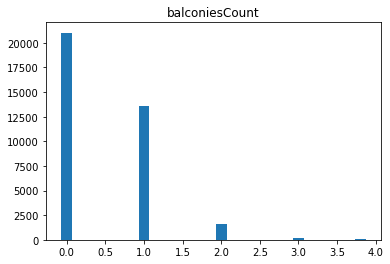

In [10]:
num_info(df.balconiesCount)

Возможно, стоит сделать признак бинарным (есть балкон или нет), но пока что оставим как есть.

Преобразуем значения в формат int32

In [11]:
df['balconiesCount']=df['balconiesCount'].astype('int32')

## loggiasCount
Количество лоджий

In [12]:
# Аналогично балконам, заменим пропуски на нули.
df.loggiasCount = df.loggiasCount.fillna(0)

Количество пропусков: 0,
count    36509.000000
mean         0.320962
std          0.573581
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: loggiasCount, dtype: float64,


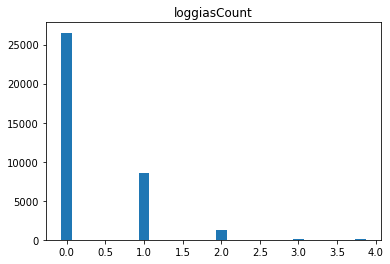

In [13]:
num_info(df.loggiasCount)

Преобразуем значения в формат int32

In [14]:
df['loggiasCount']=df['loggiasCount'].astype('int32')

## category
Категория объявления - новая квартира или вторичное жилье

In [15]:
cat_info(df.category)

Количество пропусков: 0,
count        36509
unique           2
top       flatSale
freq         31701
Name: category, dtype: object,
Распределение:
flatSale               31701
newBuildingFlatSale     4808
Name: category, dtype: int64,


Пропусков нет. Сделаем признак бинарным и переименуем колонку в newBuilding.

In [16]:
dic_category = {
    'newBuildingFlatSale': 1,
    'flatSale': 0,
}
df['category'] = df['category'].map(dic_category)
df.rename(columns = {'category':'newBuilding'}, inplace = True) 

## flatType
Тип квартиры (комнаты, студия, свободная планировка)

In [17]:
cat_info(df.flatType)

Количество пропусков: 0,
count     36509
unique        3
top       rooms
freq      33761
Name: flatType, dtype: object,
Распределение:
rooms       33761
studio       2195
openPlan      553
Name: flatType, dtype: int64,


## floorsCount
Количество этажей в здании

Количество пропусков: 0,
count    36509.000000
mean         8.964475
std          5.640262
min          1.000000
25%          5.000000
50%          8.000000
75%         12.000000
max         45.000000
Name: floorsCount, dtype: float64,


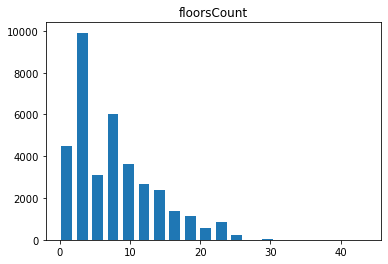

In [18]:
num_info(df.floorsCount)

## floorNumber
Этаж

Всего один пропуск в восьмиэтажном здании. Удалим пропуск.

In [19]:
df = df[df['floorNumber'].isna() == False]

Количество пропусков: 0,
count    36508.000000
mean         5.076449
std          4.112924
min         -2.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         27.000000
Name: floorNumber, dtype: float64,


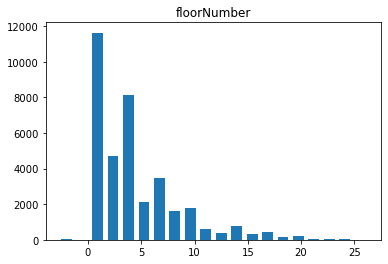

In [20]:
num_info(df.floorNumber)

Всего один пропуск в восьмиэтажном здании. Удалим пропуск.

In [21]:
df = df[df['floorNumber'].isna() == False]

На основании признаков floorNumber и floorsCount можем сгенерировать новые признаки:
* isBasement - в случае, если этаж ниже первого
* isFristFloor - первый этаж
* isLastFloor - последний этаж

Преобразуем значения в формат int32

In [22]:
df['floorNumber']=df['floorNumber'].astype('int32')

## fromDeveloper
От застройщика?

In [23]:
cat_info(df.fromDeveloper)

Количество пропусков: 0,
count     36508
unique        2
top       False
freq      34094
Name: fromDeveloper, dtype: object,
Распределение:
False    34094
True      2414
Name: fromDeveloper, dtype: int64,


Заменим значения на 1 и 0

## isApartments
Является ли квартира апартаментами

In [24]:
cat_info(df.isApartments)

Количество пропусков: 15807,
count     20701
unique        2
top       False
freq      18058
Name: isApartments, dtype: object,
Распределение:
False    18058
True      2643
Name: isApartments, dtype: int64,


Заменим пропуски на False. Раз значение не указано, скорее всего квартира апартаментами не является.

In [25]:
df.isApartments = df.isApartments.fillna(False)

## isAuction
Является ли продажа аукционом?

In [26]:
cat_info(df.isAuction)

Количество пропусков: 0,
count     36508
unique        2
top       False
freq      31919
Name: isAuction, dtype: object,
Распределение:
False    31919
True      4589
Name: isAuction, dtype: int64,


## totalArea
Общая площадь

Количество пропусков: 0,
count    36508.000000
mean        66.756973
std         54.156476
min         10.000000
25%         42.000000
50%         57.000000
75%         76.900000
max       5471.000000
Name: totalArea, dtype: float64,


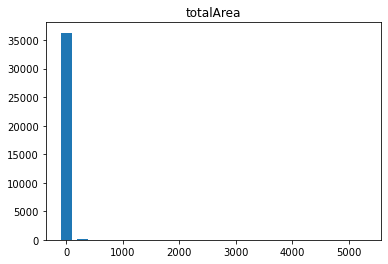

In [27]:
num_info(df.totalArea)

Отбросим выбросы

In [28]:
# закомментируем т.к. долго считает
get_iqr_col(df.totalArea)

Медиана: 57.0, 25-й перцентиль: 42.0, 75-й перцентиль: 76.9, IQR: 34.900000000000006,  Границы выбросов: [-10.350000000000009, 129.25].


Квартиры с площадью более более 129.25 м^2 являются выбросами. Отбросим эти квартиры.

In [29]:
df = df[df.totalArea <= 129.25]

## livingArea
Жилая площадь

Видим большое количество пропусков. Заменим пропуски на средний процент от общей площади.b

In [30]:
meanLivAreaRatio = df[df.livingArea.isna()==False].livingArea.mean() / df[df.livingArea.isna()==False].totalArea.mean()
df.livingArea = df.livingArea.fillna(df.totalArea * meanLivAreaRatio)

Количество пропусков: 0,
count    34297.000000
mean        33.680208
std         15.180861
min          1.000000
25%         21.292498
50%         31.100000
75%         42.009522
max        126.700000
Name: livingArea, dtype: float64,


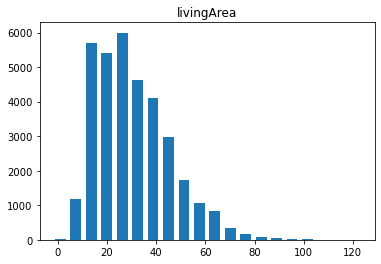

In [31]:
num_info(df.livingArea)

## kitchenArea
Площадь кухни

Ананлогично жилой площади, заменим пропуски на средную площадь в зависимости от раздела общей площади

In [32]:
meanKitchenAreaRatio = df[df.kitchenArea.isna()==False].kitchenArea.mean() / df[df.kitchenArea.isna()==False].totalArea.mean()
df.kitchenArea = df.kitchenArea.fillna(df.totalArea * meanKitchenAreaRatio)

Количество пропусков: 0,
count    34297.000000
mean        11.201111
std          5.487708
min          1.000000
25%          7.349240
50%         10.000000
75%         13.779825
max         70.900000
Name: kitchenArea, dtype: float64,


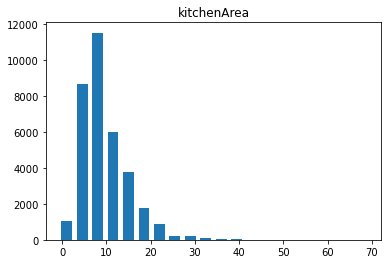

In [33]:
num_info(df.kitchenArea)

## roomsCount
Количество комнат

Заменим пропуски на среднее значение в зависимости от общей площади

In [34]:
meanRoomsCountRatio = df[df.roomsCount.isna()==False].roomsCount.mean() / df[df.roomsCount.isna()==False].totalArea.mean()
df.roomsCount = df.roomsCount.fillna(round(df.totalArea * meanRoomsCountRatio))

Количество пропусков: 0,
count    34297.000000
mean         1.979882
std          0.877334
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: roomsCount, dtype: float64,


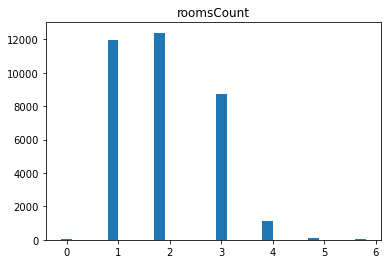

In [35]:
num_info(df.roomsCount)

Заменим количество комнат в квартирах с 0 комнатами на 1

In [36]:
dic_roomsCount = {
    0: 1,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
}
df['roomsCount'] = df['roomsCount'].map(dic_roomsCount)

Количество пропусков: 0,
count    34297.000000
mean         1.980785
std          0.875807
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: roomsCount, dtype: float64,


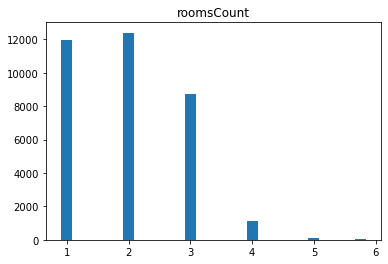

In [37]:
num_info(df.roomsCount)

## price
Стоимость квартиры, целевая переменная

Количество пропусков: 0,
count    3.429700e+04
mean     6.775966e+06
std      2.613304e+07
min      5.300000e+05
25%      3.550000e+06
50%      4.950000e+06
75%      7.200000e+06
max      3.850000e+09
Name: price, dtype: float64,


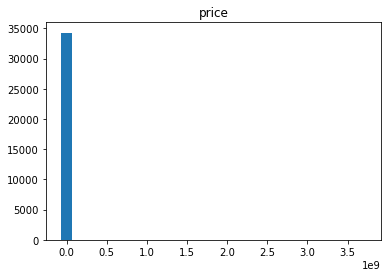

In [38]:
num_info(df.price)

Определим границы выбросов

In [39]:
get_iqr_col(df.price)

Медиана: 4950000.0, 25-й перцентиль: 3550000.0, 75-й перцентиль: 7200000.0, IQR: 3650000.0,  Границы выбросов: [-1925000.0, 12675000.0].


Медиана: 4950000.0, 25-й перцентиль: 3550000.0, 75-й перцентиль: 7200000.0, IQR: 3650000.0,  Границы выбросов: [-1925000.0, 12675000.0].

In [40]:
df = df[df['price'] <= 12675000]

## mortgageAllowed
Возможность взять в ипотеку

In [41]:
cat_info(df.mortgageAllowed)

Количество пропусков: 9993,
count     21341
unique        2
top        True
freq      16877
Name: mortgageAllowed, dtype: object,
Распределение:
True     16877
False     4464
Name: mortgageAllowed, dtype: int64,


Много пропусков и не понятно что с ними делать. Удалим признак

In [42]:
df = df.drop(['mortgageAllowed'], axis=1)

## region
Регион

In [43]:
cat_info(df.region)

Количество пропусков: 0,
count             31334
unique                3
top       Краснодарский
freq              16422
Name: region, dtype: object,
Распределение:
Краснодарский    16422
Крым             10903
Севастополь       4009
Name: region, dtype: int64,


Пропусков нет. Заменим значения на английские названия

In [44]:
dic_region = {
    'Крым': 'crimea',
    'Краснодарский': 'krasnodar',
    'Севастополь': 'sevastopol'
}
df['region'] = df['region'].map(dic_region)

## city
Город

In [45]:
cat_info(df.city)

Количество пропусков: 0,
count            31334
unique              24
top       Новороссийск
freq              4506
Name: city, dtype: object,
Распределение:
Новороссийск                4506
Анапа                       4471
Сочи                        4148
Симферополь                 3563
Геленджик                   2749
Ялта                        2735
Гагаринский                 2044
Ленинский                   1033
Евпатория                    987
Феодосия                     916
Алушта                       828
Керчь                        763
Нахимовский                  656
Симферопольский              407
Туапсе                       367
Саки                         318
Балаклавский                 302
Сакский                      189
Туапсинский                  179
Судак                        154
Кировский                      9
Бахчисарайский                 7
Крымский                       2
Севастопольская зона ЮБК       1
Name: city, dtype: int64,


<AxesSubplot:>

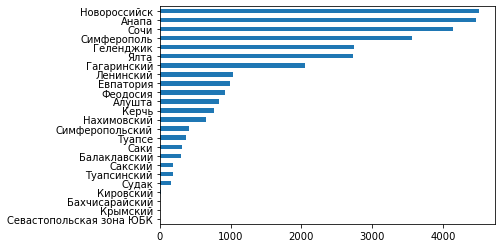

In [46]:
df['city'].value_counts(ascending=True).plot(kind='barh')

Пропусков нет. Заменим значения на английские названия, отбросим города с количеством квартир < 150

In [47]:
dic_city = {
    'Новороссийск': 'novorossiysk',
    'Анапа': 'anapa',
    'Сочи': 'sochi',
    'Симферополь': 'simferopol',
    'Геленджик': 'gelendzhik',
    'Ялта': 'yalta',
    'Гагаринский': 'gagarinskiy',
    'Ленинский': 'leninskiy',
    'Евпатория': 'evpatoriya',
    'Феодосия': 'feodosiya',
    'Алушта': 'alushta',
    'Керчь': 'kerch',
    'Нахимовский': 'nakhimovskiy',
    'Симферопольский': 'simferopolskiy',
    'Туапсе': 'tuapse',
    'Саки': 'saki',
    'Балаклавский': 'balaklavskiy',
    'Сакский': 'sakskiy',
    'Туапсинский': 'tuapsinskiy',
    'Судак': 'sudak',
}
df['city'] = df['city'].map(dic_city)

In [48]:
df = df[df['city'].isna() == False]

In [49]:
cat_info(df.city)

Количество пропусков: 0,
count            31315
unique              20
top       novorossiysk
freq              4506
Name: city, dtype: object,
Распределение:
novorossiysk      4506
anapa             4471
sochi             4148
simferopol        3563
gelendzhik        2749
yalta             2735
gagarinskiy       2044
leninskiy         1033
evpatoriya         987
feodosiya          916
alushta            828
kerch              763
nakhimovskiy       656
simferopolskiy     407
tuapse             367
saki               318
balaklavskiy       302
sakskiy            189
tuapsinskiy        179
sudak              154
Name: city, dtype: int64,


## buildYear
Год постройки

In [50]:
df.buildYear.isnull().sum()

16413

Больше половины пропусков. Удалим признак.

In [51]:
df = df.drop(['buildYear'], axis=1)

## isComplete
Статус завершения строительства

In [52]:
cat_info(df.isComplete)

Количество пропусков: 1537,
count     29778
unique        2
top        True
freq      28546
Name: isComplete, dtype: object,
Распределение:
True     28546
False     1232
Name: isComplete, dtype: int64,


Скорее всего пропуски означают, что дом уже построен. Заменим пустые значения на true.

In [53]:
df.isComplete = df.isComplete.fillna(True)

## passengerLiftsCount
Количество пассажирских лифтов

Обработаем пропуски. Посмотрим на количество этажей в домах с пропусками.

In [54]:
df[df.passengerLiftsCount.isna() == True].floorsCount.value_counts()

5     5005
3     1430
4     1414
2     1088
9      960
6      634
10     596
1      425
7      417
8      322
16     212
12     188
11     154
20      96
13      90
14      87
17      85
18      70
15      64
19      38
21      30
25      25
23      18
24      13
22       9
26       4
27       1
30       1
Name: floorsCount, dtype: int64

В домах с количеством этажей < 6 чаще всего нет лифтов

In [55]:
df[df['floorsCount'] <= 5].passengerLiftsCount.value_counts()

0.0    3471
1.0     526
2.0      18
4.0       3
3.0       2
Name: passengerLiftsCount, dtype: int64

В домах с количеством этажей > 5 чаще всего 1 пассажирский лифт

In [56]:
df[df['floorsCount'] > 5].passengerLiftsCount.value_counts()

 1.0    10726
 0.0     1767
 2.0     1119
 3.0      122
 4.0       83
-1.0        2
Name: passengerLiftsCount, dtype: int64

Заменим пропуски

In [57]:
df.loc[df.passengerLiftsCount==-1, 'passengerLiftsCount'] = 1

In [58]:
df.loc[df['floorsCount'] <= 5, 'passengerLiftsCount'] = df[df['floorsCount'] <= 5].passengerLiftsCount.fillna(0)
df.loc[df['floorsCount'] > 5, 'passengerLiftsCount'] = df[df['floorsCount'] > 5].passengerLiftsCount.fillna(1)

Заменим значение -1 на 1

In [59]:
df.loc[df.passengerLiftsCount==-1, 'passengerLiftsCount'] = 1

Количество пропусков: 0,
count    31315.000000
mean         0.586237
std          0.609841
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: passengerLiftsCount, dtype: float64,


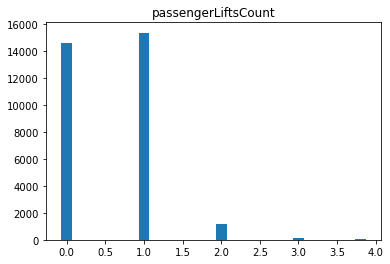

In [60]:
num_info(df.passengerLiftsCount)

In [61]:
#Преобразуем значения в формат int32
df['passengerLiftsCount']=df['passengerLiftsCount'].astype('int32')

Сделаем признак бинарным категориальным

In [62]:
df['passengerLiftsCount'] = df['passengerLiftsCount'].apply(lambda x: 0 if x == 0 else 1)

## cargoLiftsCount
Количество грузовых лифтов

Заменим пропуски на 0

In [63]:
df.cargoLiftsCount = df.cargoLiftsCount.fillna(0)

Количество пропусков: 0,
count    31315.000000
mean         0.163213
std          0.398183
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: cargoLiftsCount, dtype: float64,


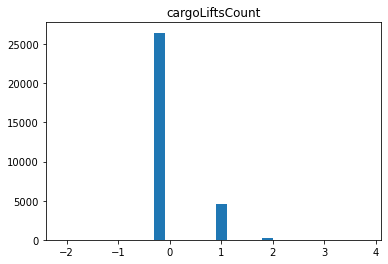

In [64]:
num_info(df.cargoLiftsCount)

Заменим значение -2 на 2

In [65]:
df.loc[df.cargoLiftsCount==-2, 'cargoLiftsCount'] = 2

In [66]:
#Преобразуем значения в формат int32
df['cargoLiftsCount']=df['cargoLiftsCount'].astype('int32')

Сделаем признак бинарным категориальным

In [67]:
df['cargoLiftsCount'] = df['cargoLiftsCount'].apply(lambda x: 0 if x == 0 else 1)

## materialType
Материал дома

In [68]:
cat_info(df.materialType)

Количество пропусков: 10015,
count        21300
unique          12
top       monolith
freq          9771
Name: materialType, dtype: object,
Распределение:
monolith             9771
block                4360
panel                3346
brick                2567
monolithBrick        1070
stalin                102
old                    44
wood                   24
aerocreteBlock          7
foamConcreteBlock       5
wireframe               3
gasSilicateBlock        1
Name: materialType, dtype: int64,


Заменим пропуски на значение unknown

In [69]:
df.materialType = df.materialType.fillna('unknown')

## Итоги первичного осмотра данных

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31315 entries, 1 to 36508
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   balconiesCount       31315 non-null  int32  
 1   newBuilding          31315 non-null  int64  
 2   flatType             31315 non-null  object 
 3   floorNumber          31315 non-null  int32  
 4   fromDeveloper        31315 non-null  bool   
 5   isApartments         31315 non-null  bool   
 6   isAuction            31315 non-null  bool   
 7   kitchenArea          31315 non-null  float64
 8   livingArea           31315 non-null  float64
 9   loggiasCount         31315 non-null  int32  
 10  roomsCount           31315 non-null  int64  
 11  totalArea            31315 non-null  float64
 12  price                31315 non-null  int64  
 13  region               31315 non-null  object 
 14  city                 31315 non-null  object 
 15  floorsCount          31315 non-null 

В результате данного шага мы оставили 20 признаков и избавились от пропусков.

# Генерация признаков

## hasBalcony
сгенерируем новый признак, значения которого будут равняться сумме количества лоджий и балконов т.к. для жильцов большой разницы нет (как мне кажется).

In [71]:
df['hasBalcony'] = df.loggiasCount + df.balconiesCount

In [72]:
cat_info(df.hasBalcony)

Количество пропусков: 0,
count    31315.000000
mean         0.778381
std          0.732156
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: hasBalcony, dtype: float64,
Распределение:
1    15127
0    11866
2     3839
3      385
4       87
6        6
5        3
8        2
Name: hasBalcony, dtype: int64,


Сделаем признак бинарным категориальным и удалим отдельные признаки по количеству балконов или лоджий.

In [73]:
df['hasBalcony'] = df['hasBalcony'].apply(lambda x: 0 if x == 0 else 1)

In [74]:
df = df.drop(['loggiasCount'], axis=1)
df = df.drop(['balconiesCount'], axis=1)

## isBasement
Находится ли квартира в подвале

In [75]:
df['isBasement'] = df['floorNumber'].apply(lambda x: 1 if x < 0 else 0)

In [76]:
df.isBasement.value_counts()

0    31277
1       38
Name: isBasement, dtype: int64

## isFirstFloor
Находится ли квартира на первом этаже

In [77]:
df['isFirstFloor'] = df['floorNumber'].apply(lambda x: 1 if x == 1 else 0)

In [78]:
df.isFirstFloor.value_counts()

0    25622
1     5693
Name: isFirstFloor, dtype: int64

Заменим отрицательные значения в признаке floorNumber т.к. возникнут проблемы при логорифмировании

In [79]:
df['floorNumber'] = df['floorNumber'].apply(lambda x: 1 if x < 0 else x)

## isLastFloor
Находится ли квартира на последнем этаже

In [80]:
# Создадим для начала вспомогательный признак - номер этажа, если считать сверху вниз.
df['backwardFloorNumber']=df['floorsCount']-df['floorNumber']

In [81]:
df['isLastFloor'] = df['backwardFloorNumber'].apply(lambda x: 1 if x == 0 else 0)

In [82]:
df.isLastFloor.value_counts()

0    24929
1     6386
Name: isLastFloor, dtype: int64

In [83]:
df = df.drop(['backwardFloorNumber'], axis=1)

## cityPopulation
Население города

Добавим данные о населении города, взяв информацию из Википедии.

In [84]:
dic_cityPopulation = {
    'novorossiysk': 274956,
    'anapa': 88879,
    'sochi': 443562,
    'simferopol': 342054,
    'gelendzhik': 76783,
    'yalta': 79056,
    'gagarinskiy': 159017,
    'leninskiy': 58441,
    'evpatoriya': 108248,
    'feodosiya': 68001,
    'alushta': 30088,
    'kerch': 151548,
    'nakhimovskiy': 119507,
    'simferopolskiy': 161997,
    'tuapse': 61180,
    'saki': 24654,
    'balaklavskiy': 51092,
    'sakskiy': 76426,
    'tuapsinskiy': 127717,
    'sudak': 16489,
}
df['cityPopulation'] = df['city'].map(dic_cityPopulation)

## cityArea
Площадь города

Добавим данные о площади города, взяв информацию из Википедии.

In [85]:
dic_cityArea = {
    'novorossiysk': 83.5,
    'anapa': 59,
    'sochi': 176.8,
    'simferopol': 107.4,
    'gelendzhik': 19.25,
    'yalta': 18.2,
    'gagarinskiy': 61.1,
    'leninskiy': 2918.6,
    'evpatoriya': 65,
    'feodosiya': 40,
    'alushta': 7,
    'kerch': 108,
    'nakhimovskiy': 267.7,
    'simferopolskiy': 1752.5,
    'tuapse': 33.4,
    'saki': 28.7,
    'balaklavskiy': 530.3,
    'sakskiy': 2257.5,
    'tuapsinskiy': 2399.2,
    'sudak': 23.5,
}
df['cityArea'] = df['city'].map(dic_cityArea)

## populationDensity
Плотность населения

In [86]:
df['populationDensity'] = df.cityPopulation / df.cityArea

## areaPerRoom
Отношение общей площади к количеству комнат

In [87]:
df['areaPerRoom'] = df.totalArea / df.roomsCount

# Промежуточные итоги

In [88]:
df.head()

,newBuilding,flatType,floorNumber,fromDeveloper,isApartments,isAuction,kitchenArea,livingArea,roomsCount,totalArea,...,cargoLiftsCount,materialType,hasBalcony,isBasement,isFirstFloor,isLastFloor,cityPopulation,cityArea,populationDensity,areaPerRoom
1,0,rooms,2,False,False,True,10.411423,26.000000,1,54.40,...,0,monolithBrick,1,0,0,0,79056,18.2,4343.736264,54.40
3,1,rooms,7,True,False,True,8.091819,24.330994,1,42.28,...,0,monolith,0,0,0,0,79056,18.2,4343.736264,42.28
6,1,rooms,6,True,True,True,10.124343,30.442517,1,52.90,...,0,monolith,0,0,0,0,79056,18.2,4343.736264,52.90
8,0,rooms,2,False,True,True,10.000000,13.811350,1,24.00,...,0,monolith,1,0,0,0,79056,18.2,4343.736264,24.00
9,0,rooms,3,False,False,True,8.612390,25.896281,1,45.00,...,1,monolith,1,0,0,0,79056,18.2,4343.736264,45.00


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31315 entries, 1 to 36508
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   newBuilding          31315 non-null  int64  
 1   flatType             31315 non-null  object 
 2   floorNumber          31315 non-null  int64  
 3   fromDeveloper        31315 non-null  bool   
 4   isApartments         31315 non-null  bool   
 5   isAuction            31315 non-null  bool   
 6   kitchenArea          31315 non-null  float64
 7   livingArea           31315 non-null  float64
 8   roomsCount           31315 non-null  int64  
 9   totalArea            31315 non-null  float64
 10  price                31315 non-null  int64  
 11  region               31315 non-null  object 
 12  city                 31315 non-null  object 
 13  floorsCount          31315 non-null  int64  
 14  isComplete           31315 non-null  bool   
 15  passengerLiftsCount  31315 non-null 

Мы сгенерировали 8 новых признаков, некоторые удалили. Теперь их общее количество - 26.

   * Числовые - 11: floorNumber, kitchenArea, livingArea, roomsCount, totalArea, floorsCount, cityPopulation, cityArea, populationDensity, areaPerRoom и целевая переменная price
   * Категориальные оценочные - 4 шт.: flatType, region, city, materialType
   * Категориальные бинарные - 11 шт.: newBuilding, fromDeveloper, isApartments, isAuction, isComplete, hasBalcony, isBasement, isFirstFloor, isLastFloor, passengerLiftsCount, cargoLiftsCount

In [90]:
# Составим список бинарных категориальных признаков:
bin_features = [
    'newBuilding',
    'fromDeveloper',
    'isApartments',
    'isAuction',
    'isComplete',
    'hasBalcony',
    'isBasement',
    'isFirstFloor',
    'isLastFloor',
    'passengerLiftsCount',
    'cargoLiftsCount',
]

# Составим список категориальных признаков:
cat_features = [
    'flatType',
    'region',
    'city',
    'materialType',
]
 
# Составим список числовых признаков:
num_features = [
    'price',
    'floorNumber',
    'kitchenArea',
    'livingArea',
    'roomsCount',
    'totalArea',
    'floorsCount',
    'cityPopulation',
    'cityArea',
    'populationDensity',
    'areaPerRoom',
]

# Анализ полученных признаков

## Корреляционный анализ
Выясним, какие столбцы коррелируют со стоймостью квартиры.
Корреляцию рассмотрим только для числовых столбцов.

<AxesSubplot:>

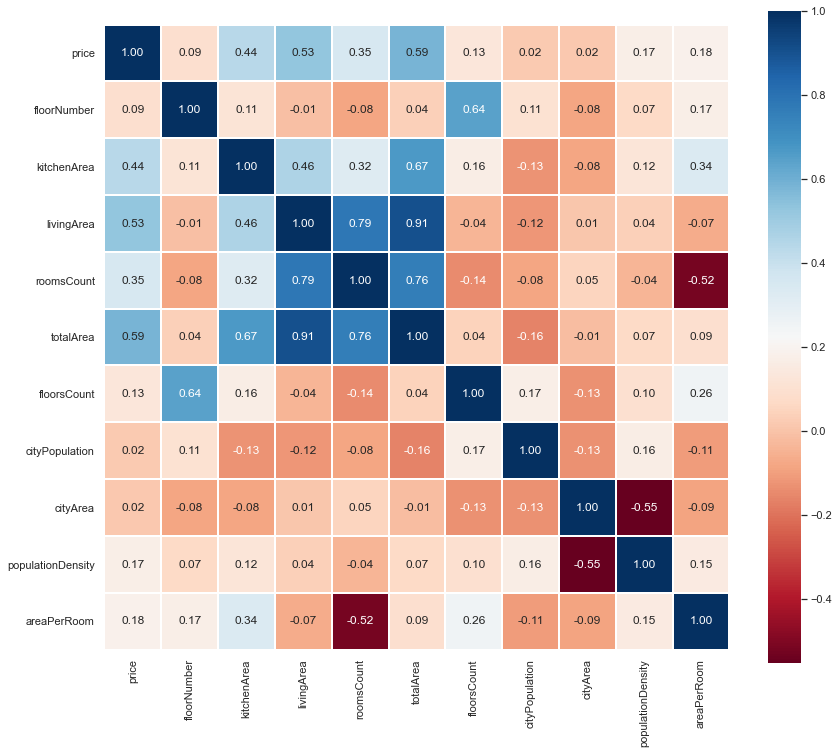

In [91]:
# Проверяем на мультиколлинеарность и кореляцию числовых признаков между собой и с главным признаком "price":
sns.set(font_scale=1)
plt.subplots(figsize=(14, 12))
sns.heatmap(df[num_features].corr(), square=True, annot=True,
            fmt=".2f", linewidths=1, cmap="RdBu")

Сильно скоррелированы между собой признаки totalArea и livingArea.

Посмотрим, как выглядят распределения числовых признаков

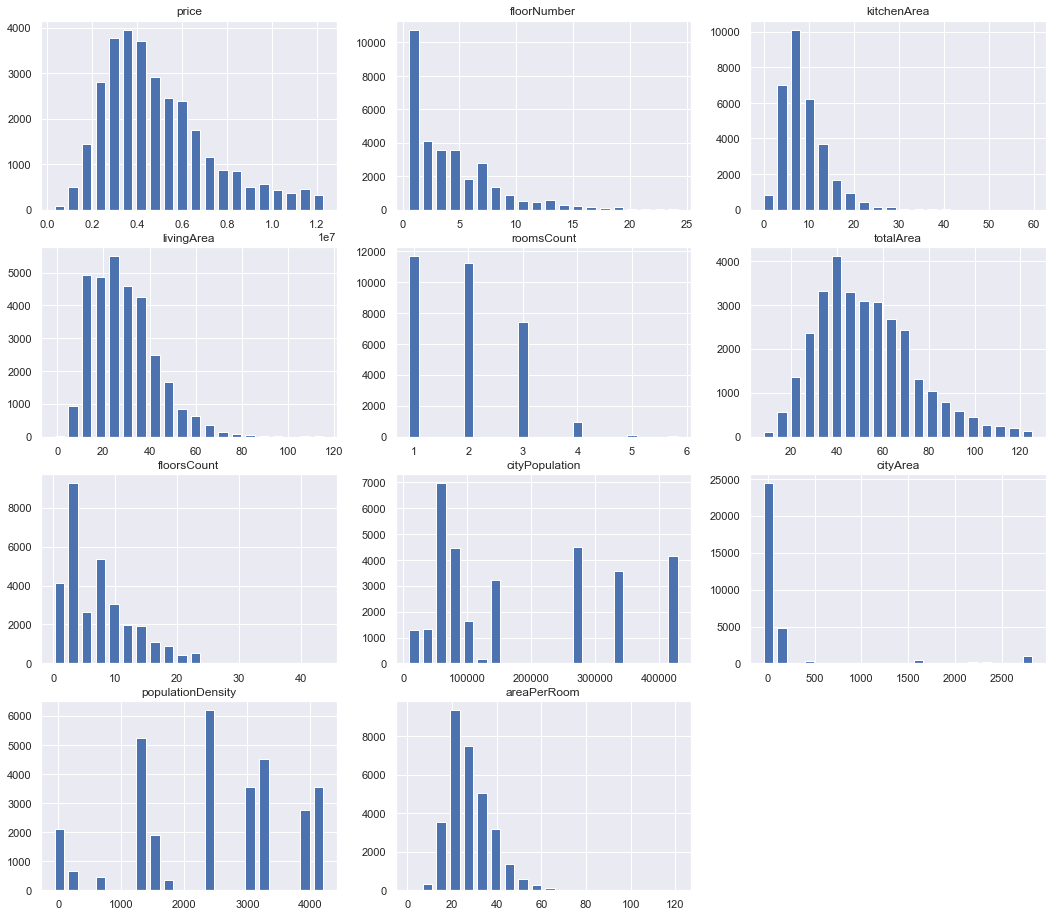

In [92]:
visualize_distributions({
    'price': df.price,
    'floorNumber': df.floorNumber,
    'kitchenArea': df.kitchenArea,
    'livingArea': df.livingArea,
    'roomsCount': df.roomsCount,
    'totalArea': df.totalArea,
    'floorsCount': df.floorsCount,
    'cityPopulation': df.cityPopulation,
    'cityArea': df.cityArea,
    'populationDensity': df.populationDensity,
    'areaPerRoom': df.areaPerRoom,
})

Видим, что числовые признаки необходимо будет нормализовть и логорифмировать для получения нормального распределения.

## Анализ номинативных переменных
Посмотрим на распределение стоймости квартир в зависимости от значения номинативных переменных.

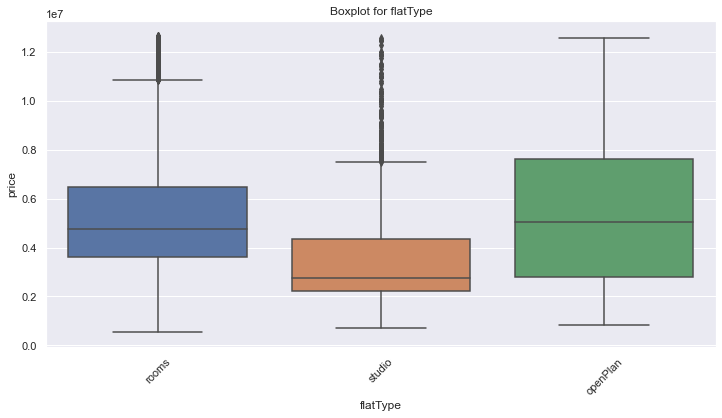

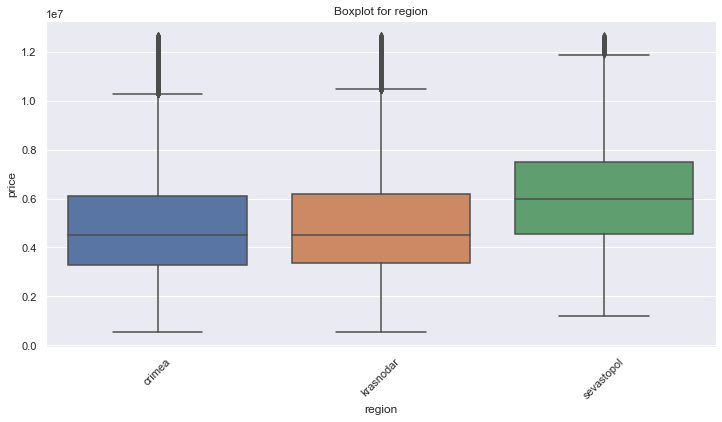

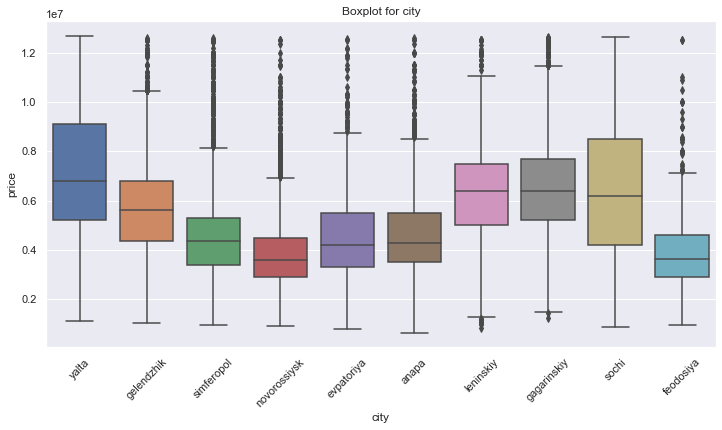

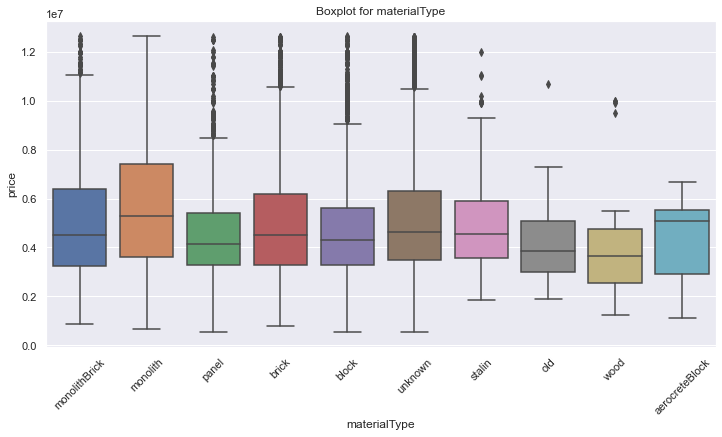

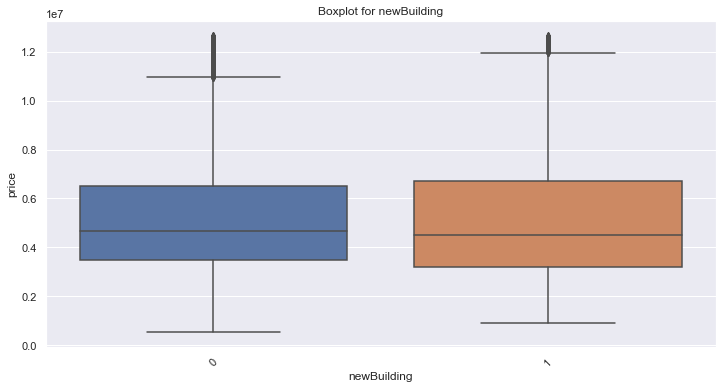

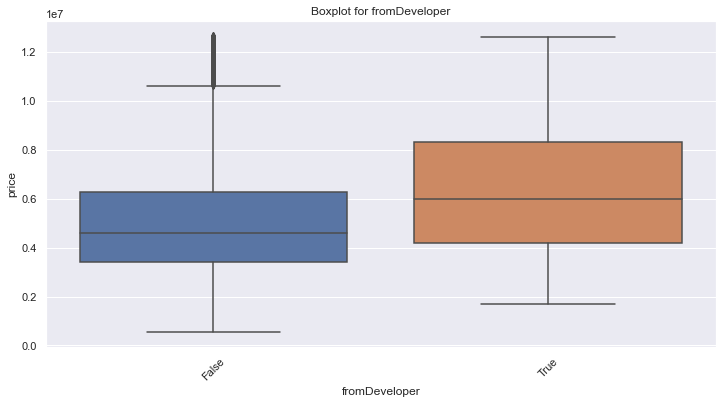

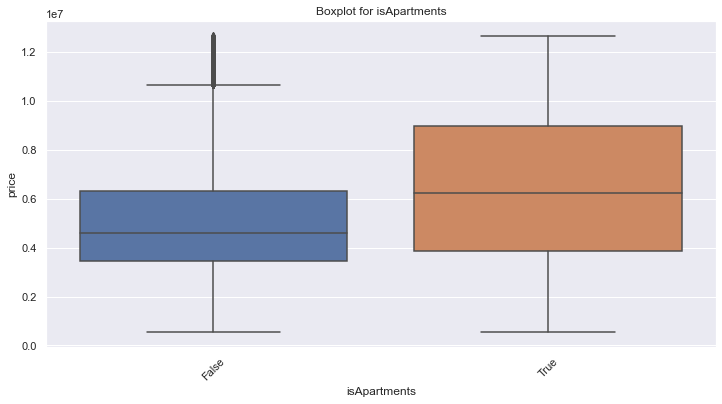

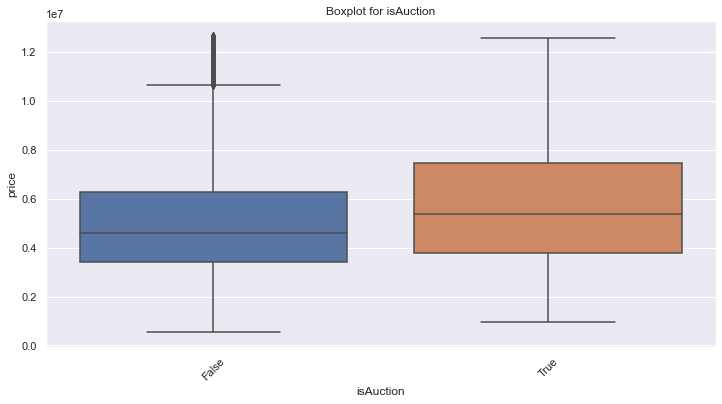

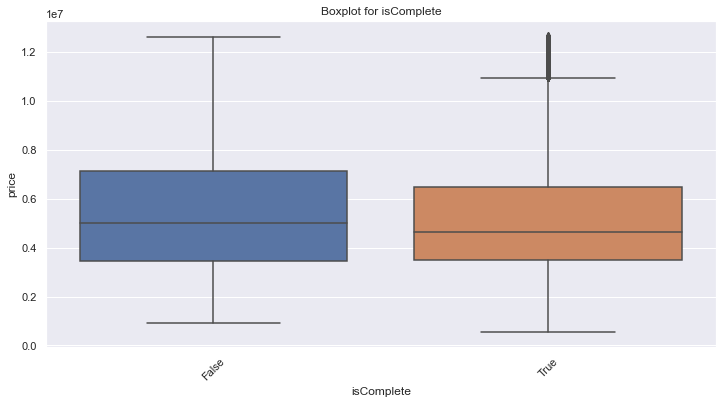

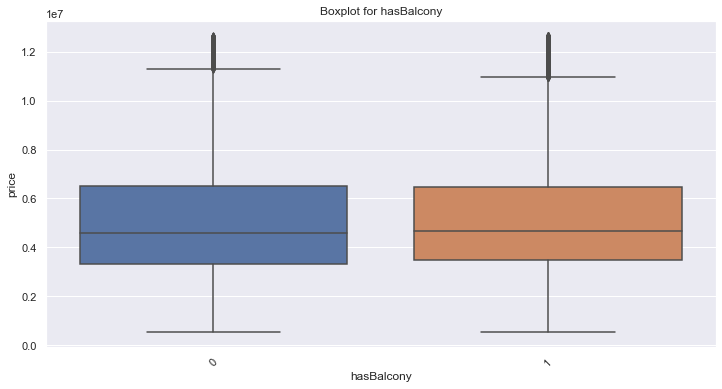

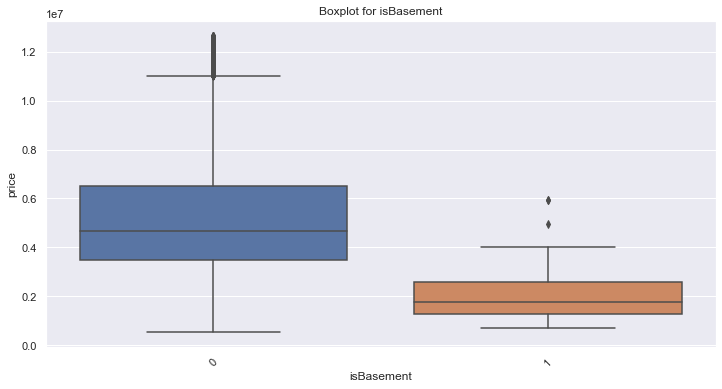

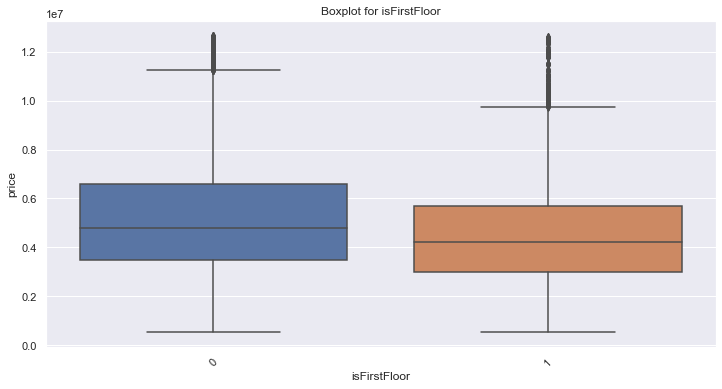

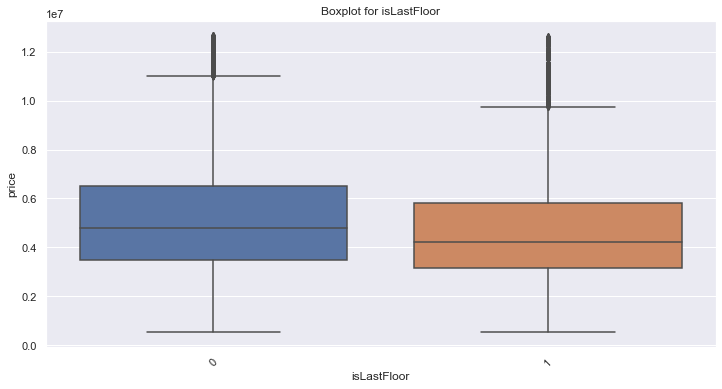

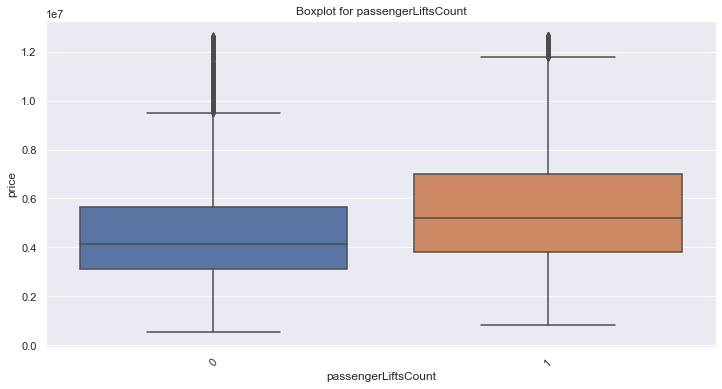

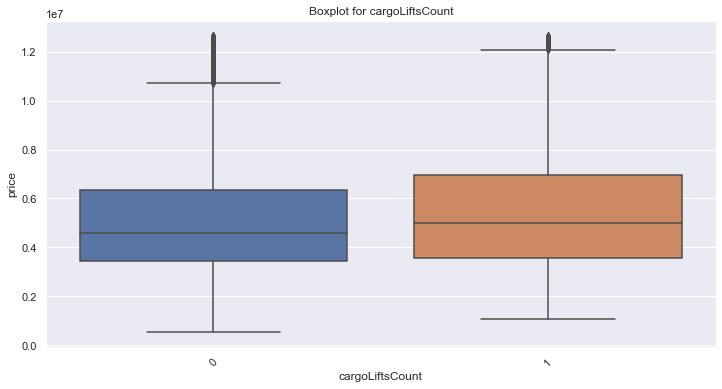

In [93]:
for col in chain(cat_features, bin_features):
    get_boxplot(col)

По графикам похоже, что все параметры, кроме newBuilding и isLastFloor могут влиять на стоимость квартиры.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения стоимости квартир по различным параметрам неразличимы:

In [94]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'], 
                        df.loc[df.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [95]:
for col in chain(cat_features, bin_features):
    get_stat_dif(col)

Найдены статистически значимые различия для колонки flatType
Найдены статистически значимые различия для колонки region
Найдены статистически значимые различия для колонки city
Найдены статистически значимые различия для колонки materialType
Найдены статистически значимые различия для колонки fromDeveloper
Найдены статистически значимые различия для колонки isApartments
Найдены статистически значимые различия для колонки isAuction
Найдены статистически значимые различия для колонки isComplete
Найдены статистически значимые различия для колонки hasBalcony
Найдены статистически значимые различия для колонки isBasement
Найдены статистически значимые различия для колонки isFirstFloor
Найдены статистически значимые различия для колонки isLastFloor
Найдены статистически значимые различия для колонки passengerLiftsCount
Найдены статистически значимые различия для колонки cargoLiftsCount


Видим, что только признак newBuilding не является значимым по тесту Стьюдента

In [96]:
# сохраним датасет
df.to_csv('cian_eda.csv', index=False)

# Отбор признаков

## Предобработка датасета

Для начала сделаем label encodong для бинарных признаков и создадим dummy-переменные для категориальных признаков

In [97]:
# label encoding
for column in bin_features:
    df[column] = df[column].astype('category').cat.codes
    
# one-hot encoding
df = pd.get_dummies(df, columns=cat_features, dummy_na=False)

In [98]:
# зададим количество признаков, которое хотим оставить
num_feats = 20

# выделим признаки и целевую переменную в датасете
y = df.price.values
X = df.drop(['price'], axis=1)

## 1. Корреляция Пирсона

Проверим абсолютное значение корреляции Пирсона между числовыми признаками и целевой переменной в нашем датасете. Оставим 20 признаков.

In [99]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # считаем корреляцию для каждого признака
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # заменяем NaN на 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # название признака
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # отобран ли признак? 0 если не отобран, 1 если отобран
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y, num_feats)
print(str(len(cor_feature)), 'selected features:')
for i in cor_feature[::-1]:
    print(i)

20 selected features:
totalArea
livingArea
kitchenArea
roomsCount
city_yalta
passengerLiftsCount
city_novorossiysk
city_sochi
areaPerRoom
flatType_studio
populationDensity
region_sevastopol
city_gagarinskiy
flatType_rooms
materialType_monolith
floorsCount
city_kerch
fromDeveloper
isFirstFloor
isApartments


## 2. Хи-квадрат (Chi-squared score)

Посчитаем метрику хи-квадрат между числовыми признаками и целевой переменной и оставим переменные с максимальным значением метрики

In [102]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features:')
for i in chi_feature[::-1]:
    print(i)

20 selected features:
materialType_monolith
city_yalta
city_tuapsinskiy
city_tuapse
city_sochi
city_simferopolskiy
city_novorossiysk
city_gagarinskiy
city_evpatoriya
city_anapa
city_alushta
region_sevastopol
region_crimea
flatType_studio
flatType_openPlan
cargoLiftsCount
isAuction
isApartments
fromDeveloper
newBuilding


## 3. Метод RFE (Recursive Feature Elimination)

Цель методе RFE состоит в том, чтобы выбрать функции, рекурсивно рассматривая все меньшие и меньшие наборы признаков. Сначала происходит обучение на начальном наборе признаков. Затем наименее важные признаки удаляются из текущего набора. Эта процедура рекурсивно повторяется для сокращенного набора, пока в конечном итоге не будет достигнуто желаемое количество признаков. 

In [104]:
rfe_selector = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features:')
for i in chi_feature[::-1]:
    print(i)

Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30 features.
20 selected features:
materialType_monolith
city_yalta
city_tuapsinskiy
city_tuapse
city_sochi
city_simferopolskiy
city_novorossiysk
city_gagarinskiy
city_evpatoriya
city_anapa
city_alushta
region_sevastopol
region_crimea
flatType_studio
flatType_openPlan
cargoLiftsCount
isAuction
isApartments
fromDeveloper
newBuilding


## 4. Lasso: SelectFromModel

Данный метод реализует l1-регуляризацию

In [106]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features:')
for i in embeded_lr_feature[::-1]:
    print(i)

20 selected features:
materialType_monolith
city_yalta
city_sochi
city_novorossiysk
city_evpatoriya
city_anapa
region_krasnodar
region_crimea
flatType_rooms
populationDensity
hasBalcony
cargoLiftsCount
passengerLiftsCount
isComplete
totalArea
roomsCount
isAuction
isApartments
fromDeveloper
newBuilding


## 5. Объединение результатов различных методов

Сведем результаты различных методов отбора признаков в единый датасет и отсортируем по количеству методов, которые выделили признак как значимый.

In [109]:
feature_selection_df = pd.DataFrame({
    'Feature':X.columns,
    'Pearson':cor_support,
    'Chi-2':chi_support,
    'RFE':rfe_support,
    'Logistics':embeded_lr_support,
})
# считаем количество раз, которе признак был отобран
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# сортируем и отображаем датасет
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(30)

,Feature,Pearson,Chi-2,RFE,Logistics,Total
1,materialType_monolith,True,True,True,True,4
2,totalArea,True,False,True,True,3
3,roomsCount,True,False,True,True,3
4,region_sevastopol,True,True,True,False,3
5,region_crimea,False,True,True,True,3
6,populationDensity,True,False,True,True,3
7,passengerLiftsCount,True,False,True,True,3
8,isApartments,True,True,False,True,3
9,fromDeveloper,True,True,False,True,3
10,flatType_studio,True,True,True,False,3


Оставим признаки, отобранные хотя бы двумя методами.

In [116]:
df_model = df[[
    'materialType_monolith',
    'totalArea',
    'roomsCount',
    'region_sevastopol',
    'region_crimea',
    'populationDensity',
    'passengerLiftsCount',
    'isApartments',
    'fromDeveloper',
    'flatType_studio',
    'flatType_rooms',
    'city_yalta',
    'city_sochi',
    'city_novorossiysk',
    'city_anapa',
    'region_krasnodar',
    'newBuilding',
    'livingArea',
    'isFirstFloor',
    'isComplete',
    'isAuction',
    'hasBalcony',
    'city_gagarinskiy',
    'city_evpatoriya',
    'cargoLiftsCount',
    'areaPerRoom',
    'price',
]]

# Результаты EDA

В результате EDA мы проделали следующую работу:
* Ознакомились с данными.
* Избавились от пропусков.
* Избавились от выбросов в переменных price и totalArea.
* Сгенерировали новые признаки.
* Провели корреляционный анализ числовых признаков.
* Посмотрели на распределение числовых признаков, в результате решили в дальнейшем нормализовать и логорифмировать числовые признаки.
* Провели анализ номинативных переменных, в результате увидили слаболе влияние параметра newBuilding на целевую переменную.
* Провели отбор признаков различными методами.

Сохраним датасет для дальнейшего использования при обучении модели.

In [117]:
df_model.to_csv('cian_model.csv', index=False)